# EDA
El objetivo de este notebook es realizar un análisis explorativo de datos, y usar este análisis para limpiar más los datos y/o preprocesarlos

In [2]:
from src.data_processing import standardize_features, log_transform_features, cap_outliers
%load_ext autoreload
%autoreload 2

import pandas as pd

from src.utils import DEV_SET_CLEAN_PATH, TARGET
from src.plots import plot_boolean_impact, plot_correlation_heatmap, plot_histograms, plot_boxplots, plot_bar_charts, \
    plot_geo_scatterplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv("../" + DEV_SET_CLEAN_PATH)

In [4]:
df.describe(include="all")

,id_grid,STotalM2,SConstrM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,BusinessCenter,Gimnasio,...,ITE_ADD_STATE_NAME,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,SUM,meses_desde_comienzo,mes_listing
count,270715.000000,2.625630e+05,2.637050e+05,270593.000000,270713.000000,269365.000000,240403,2.462150e+05,203480,238431,...,270715,258095,270715,270715.000000,270715.000000,2.707150e+05,270715.000000,214480,270715.000000,270715.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,...,4,503,3,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,...,Capital Federal,Palermo,U,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,220227,NaN,202323,209818,...,153869,15541,198204,NaN,NaN,NaN,NaN,176426,NaN,NaN
mean,59783.357649,3.966948e+03,1.720614e+03,1.415528,1.335315,2.402862,NaN,2.907292e+01,NaN,NaN,...,NaN,NaN,NaN,-58.481007,-34.598213,8.215410e+04,2021.472172,NaN,11.152702,6.521190
std,14743.238038,9.779880e+05,4.121375e+05,1.025419,1.030387,1.391798,NaN,4.419469e+03,NaN,NaN,...,NaN,NaN,NaN,0.115097,0.081543,6.757349e+05,0.499226,NaN,6.845461,3.439394
min,124.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.874595,-34.923504,4.264038e+01,2021.000000,NaN,0.000000,1.000000
25%,53517.000000,3.900000e+01,3.700000e+01,1.000000,1.000000,2.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.543363,-34.632289,6.568300e+03,2021.000000,NaN,4.960578,4.000000
50%,60080.000000,5.000000e+01,4.600000e+01,1.000000,1.000000,2.000000,NaN,7.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.449924,-34.597885,9.166979e+03,2021.000000,NaN,10.972405,7.000000
75%,65657.000000,7.800000e+01,7.000000e+01,2.000000,1.000000,3.000000,NaN,3.000000e+01,NaN,NaN,...,NaN,NaN,NaN,-58.400915,-34.566651,1.866683e+04,2022.000000,NaN,16.951380,9.000000


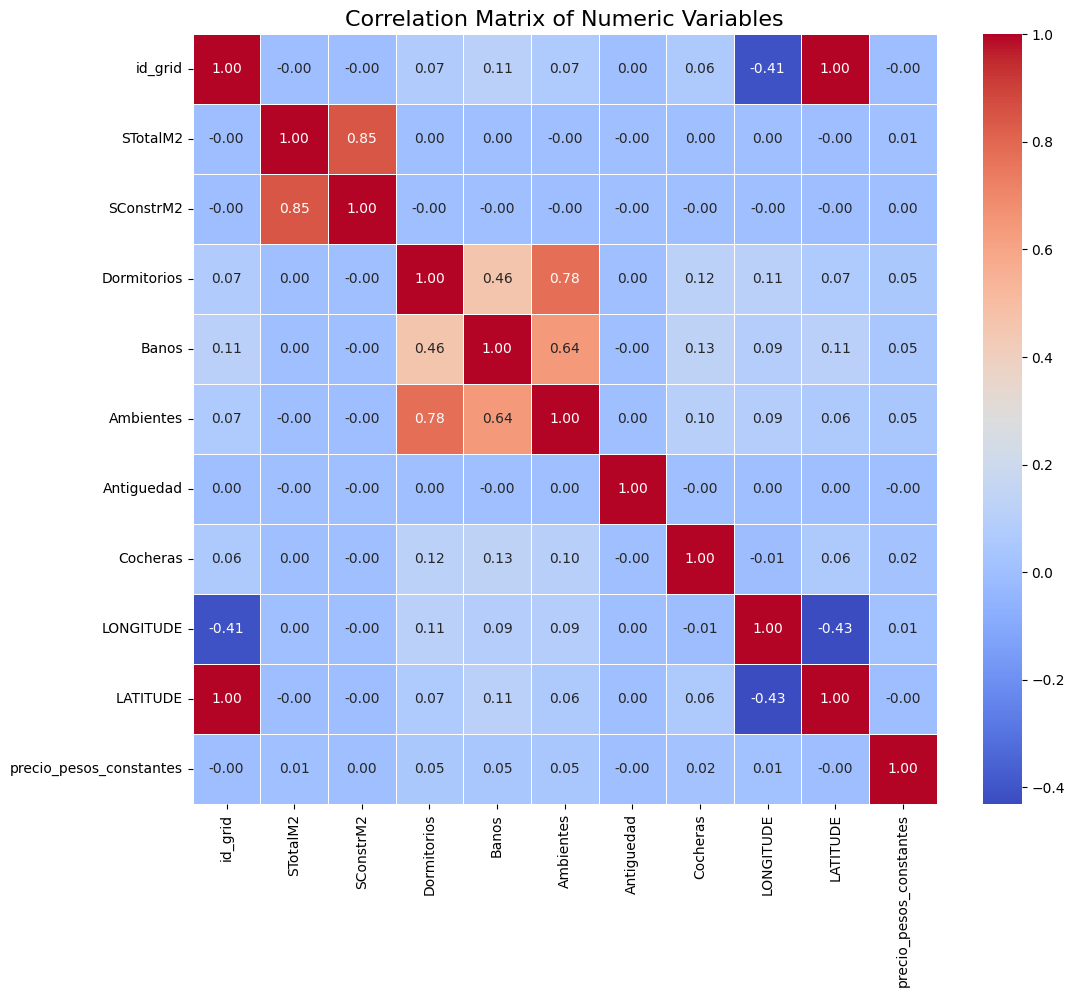

In [5]:
NUMERICAL_FEATURES = ["id_grid", "STotalM2", "SConstrM2", "Dormitorios", "Banos", "Ambientes", "Antiguedad", "Cocheras", "LONGITUDE", "LATITUDE"]
plot_correlation_heatmap(df, NUMERICAL_FEATURES + [TARGET])

A priori, no hay correlación alguna entre las variables y el targer, para ninguna feature. Esto probablemente se deba a outliers extremos, escalas muy diferentes, distribuciones sesgadas. Tenemos que trabajar el dataset antes de seguir analizando

## Análisis de Precio
Análicemos un poco la variable objetivo:

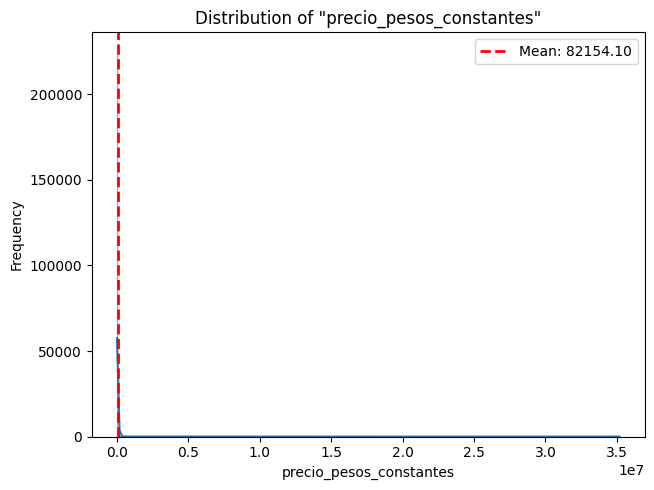

In [6]:
plot_histograms(df, [TARGET])

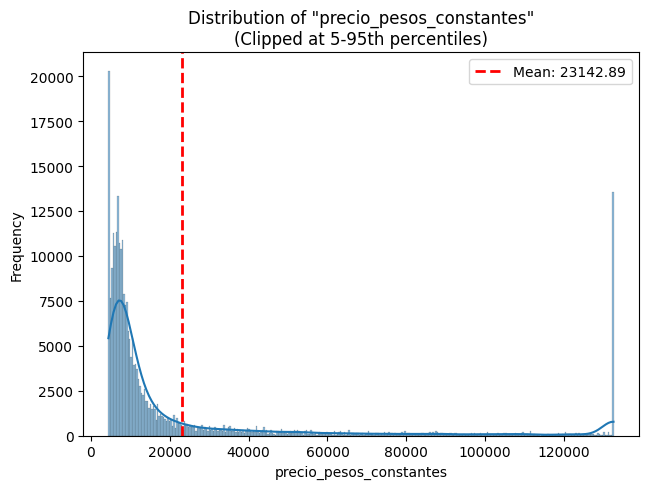

In [7]:
plot_histograms(df, [TARGET], clip_percentiles=(0.05, 0.95))

La variable objetivo (precio) está extremadamente sesgada hacia la izquierda. Esto quiere decir que la mayoría de los precios se encuentran en esa zona, mientras que hay unas pocas propiedades que tienen precios extremadamente altos. Veamos qué pasa si aplicamos el log:

In [8]:
df_log_precio = log_transform_features(df, [TARGET])

Applying log transformation to columns: precio_pesos_constantes


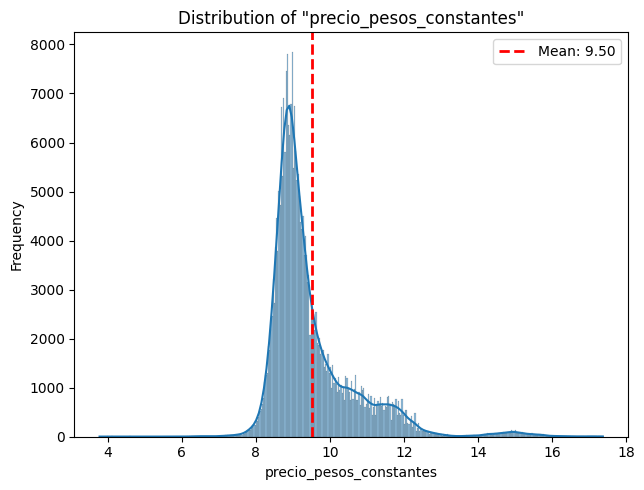

In [9]:
plot_histograms(df_log_precio, [TARGET])

La distribución de log(precio) es mucho más simpetrica y parecida a una distribución normal. Vamos a hacer que nuestro modelo prediga log(precio), lo cual va a facilitar mucho las predicciones.

## Análisis de Features Numéricas
Analicemos la distribución del resto de features numéricas:

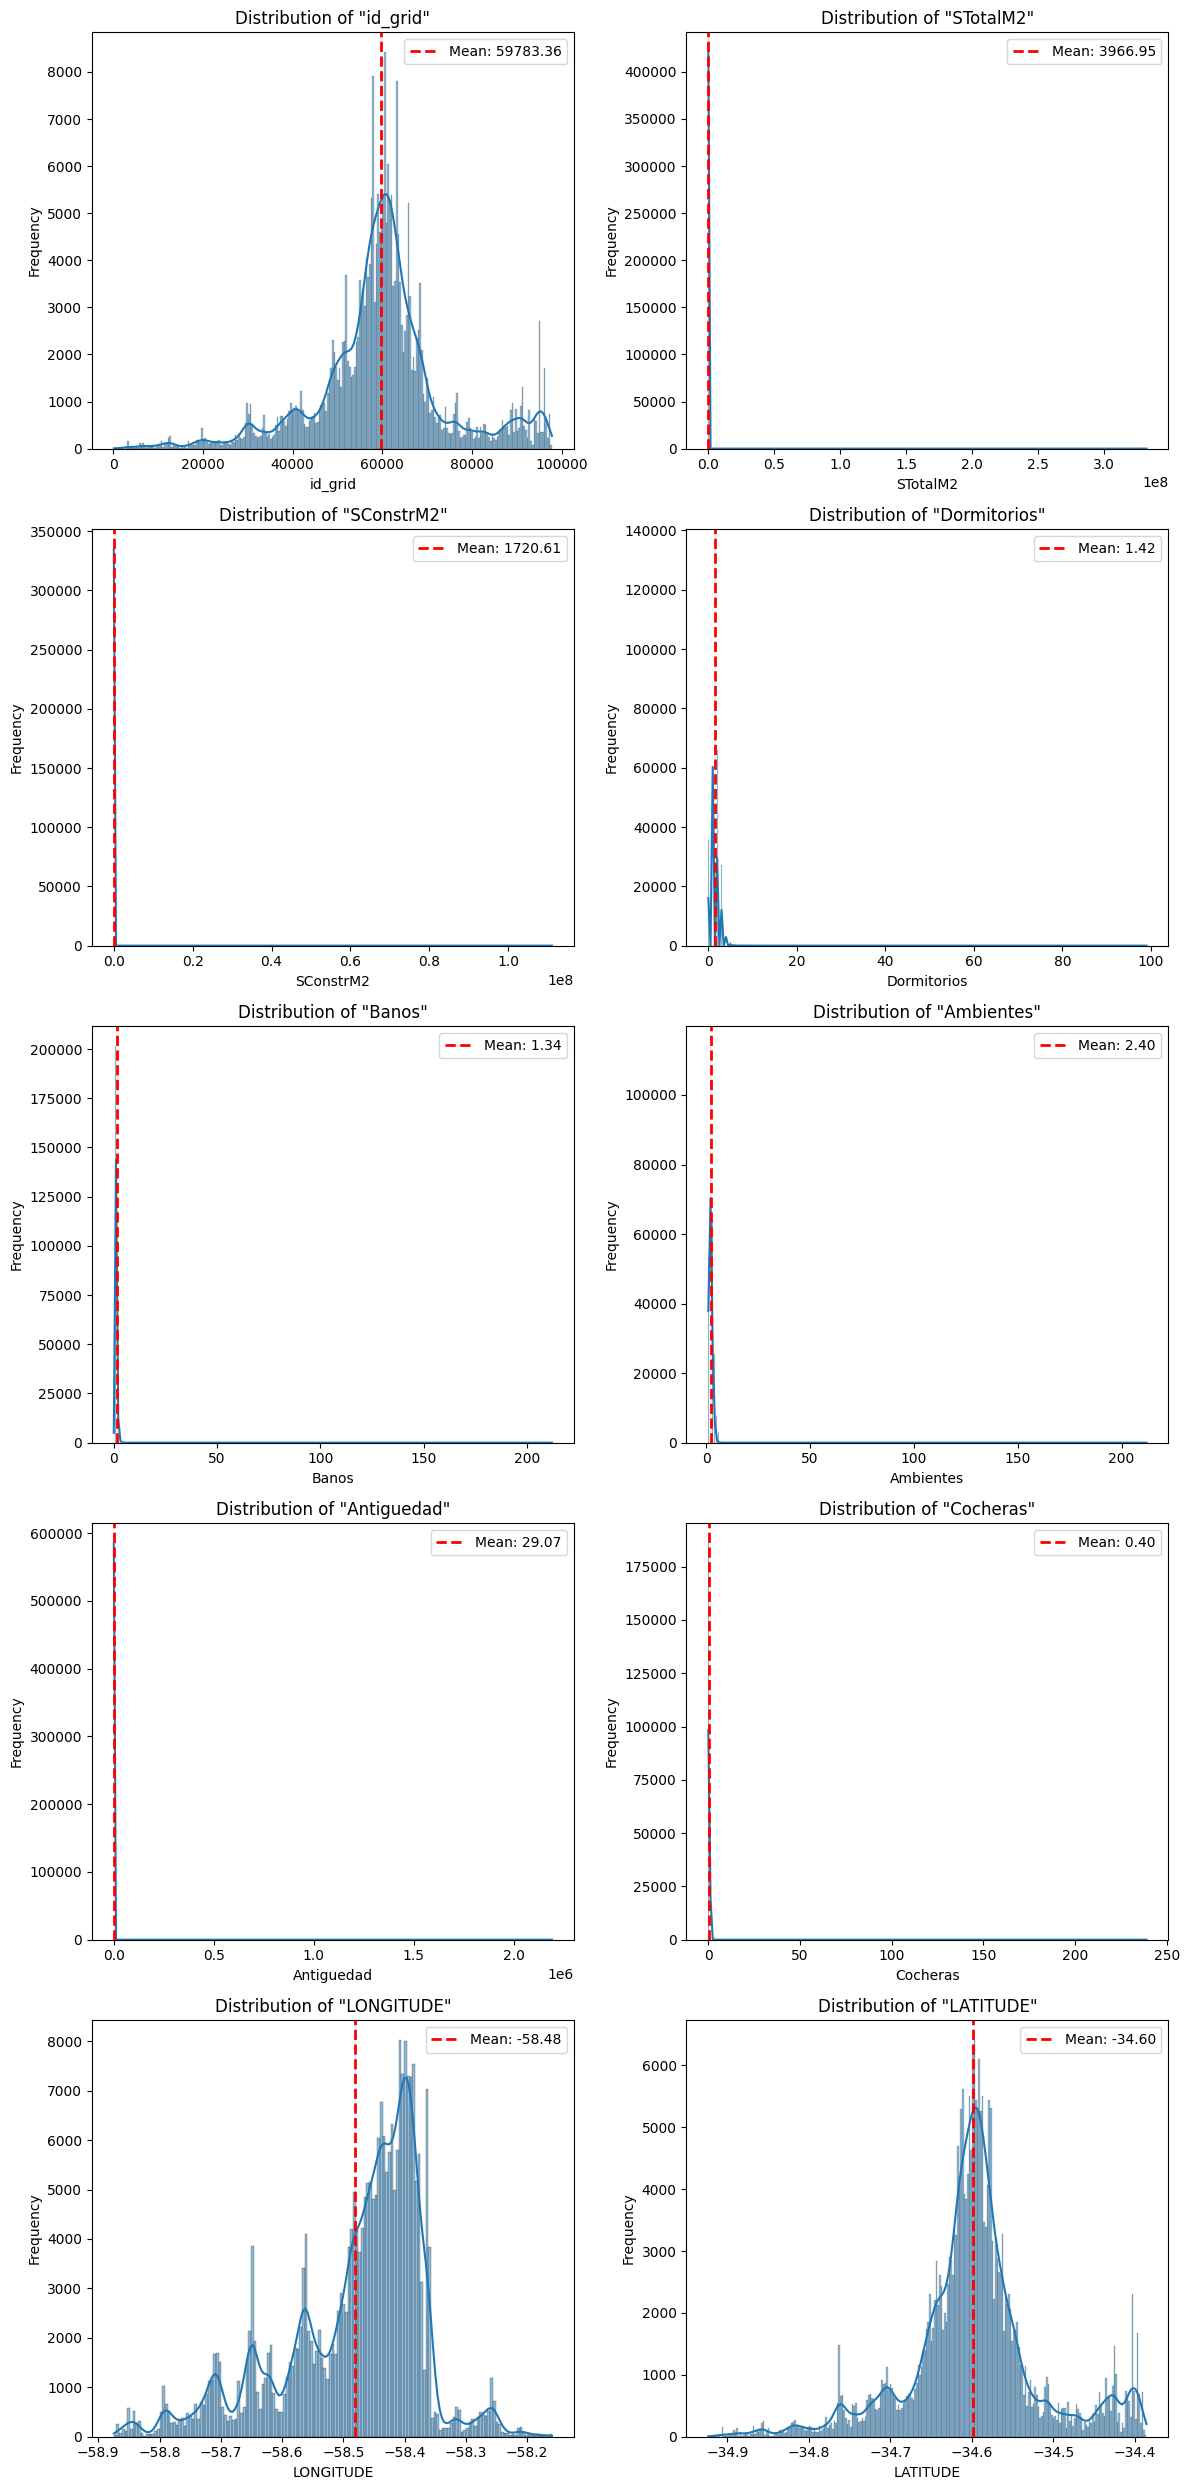

In [10]:
plot_histograms(df, NUMERICAL_FEATURES, n_cols=2)

La mayoría de features muestran una asimetría extrema. La mayoría de valores se encuentran a la

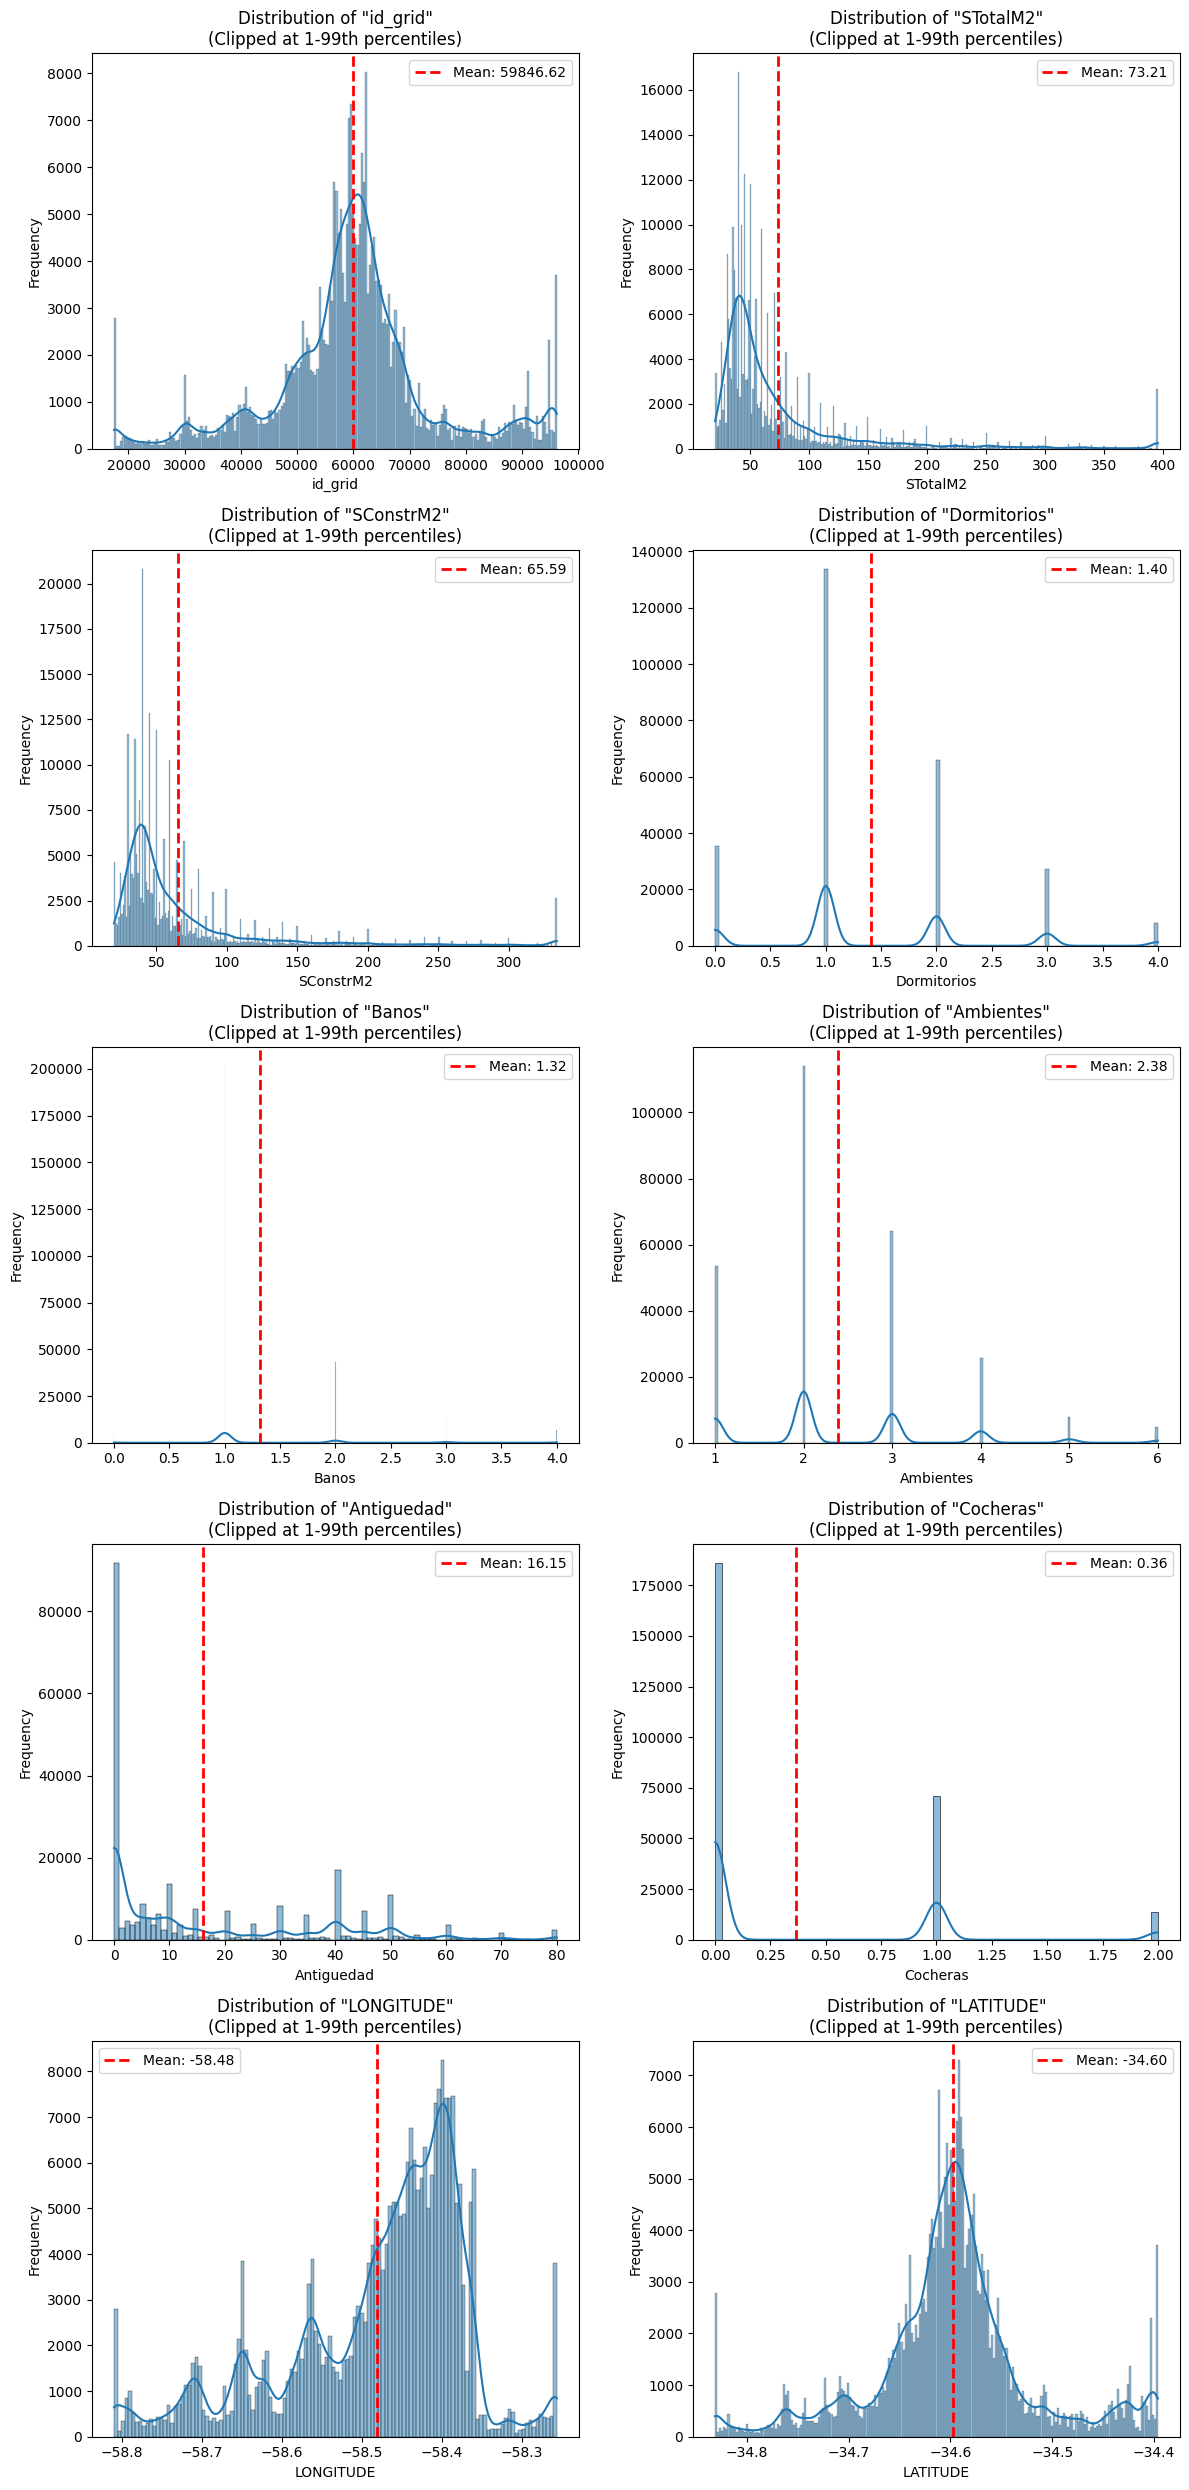

In [11]:
plot_histograms(df, NUMERICAL_FEATURES, clip_percentiles=(0.01, 0.99), n_cols=2)

Al excluir los valores realmente extremos, vemos que muchas variables pasan de ser aparentemente numéricas a categóricas. Esto sucede con Dormitorios, Banos, Ambientes, Cocheras. Al excluir outliers extremos, estas variables se mueven únicamente en valores discretos entre 0 y 6. Por ello, asumimos que esos valores extremos (que aplican solo a algunos datos) son erróneos. Vamos a capearlos al percentil más cercano

In [12]:
OUTLIER_COLS = ["Dormitorios", "Banos", "Ambientes", "Cocheras"]
df_capped, _ = cap_outliers(df_log_precio, OUTLIER_COLS, percentiles=(0.01, 0.99))

Capping outliers for columns: Dormitorios, Banos, Ambientes, Cocheras


Además, actualizamos nuestras columnas numéricas para no incluir las recién nombradas (pues pasan a ser categóricas al tener solo algunos valores posibles)

In [13]:
NUMERICAL_FEATURES = ["id_grid", "STotalM2", "SConstrM2", "Antiguedad", "LONGITUDE", "LATITUDE"]
CATEGORICAL_FEATURES = ["Dormitorios", "Banos", "Ambientes", "Amoblado", "BusinessCenter", "Gimnasio", "Laundry", "Calefaccion", "AireAC", "Recepcion", "Estacionamiento", "Jacuzzi", "Seguridad", "Pileta", "Cocheras", "CanchaTennis", "ITE_ADD_STATE_NAME", "ITE_TIPO_PROD", "year", "meses_desde_comienzo", "mes_listing"]

Todavía tenemos problemas con algunas variables numéricas. Por ejemplo,

## Análisis de Features Categóricas

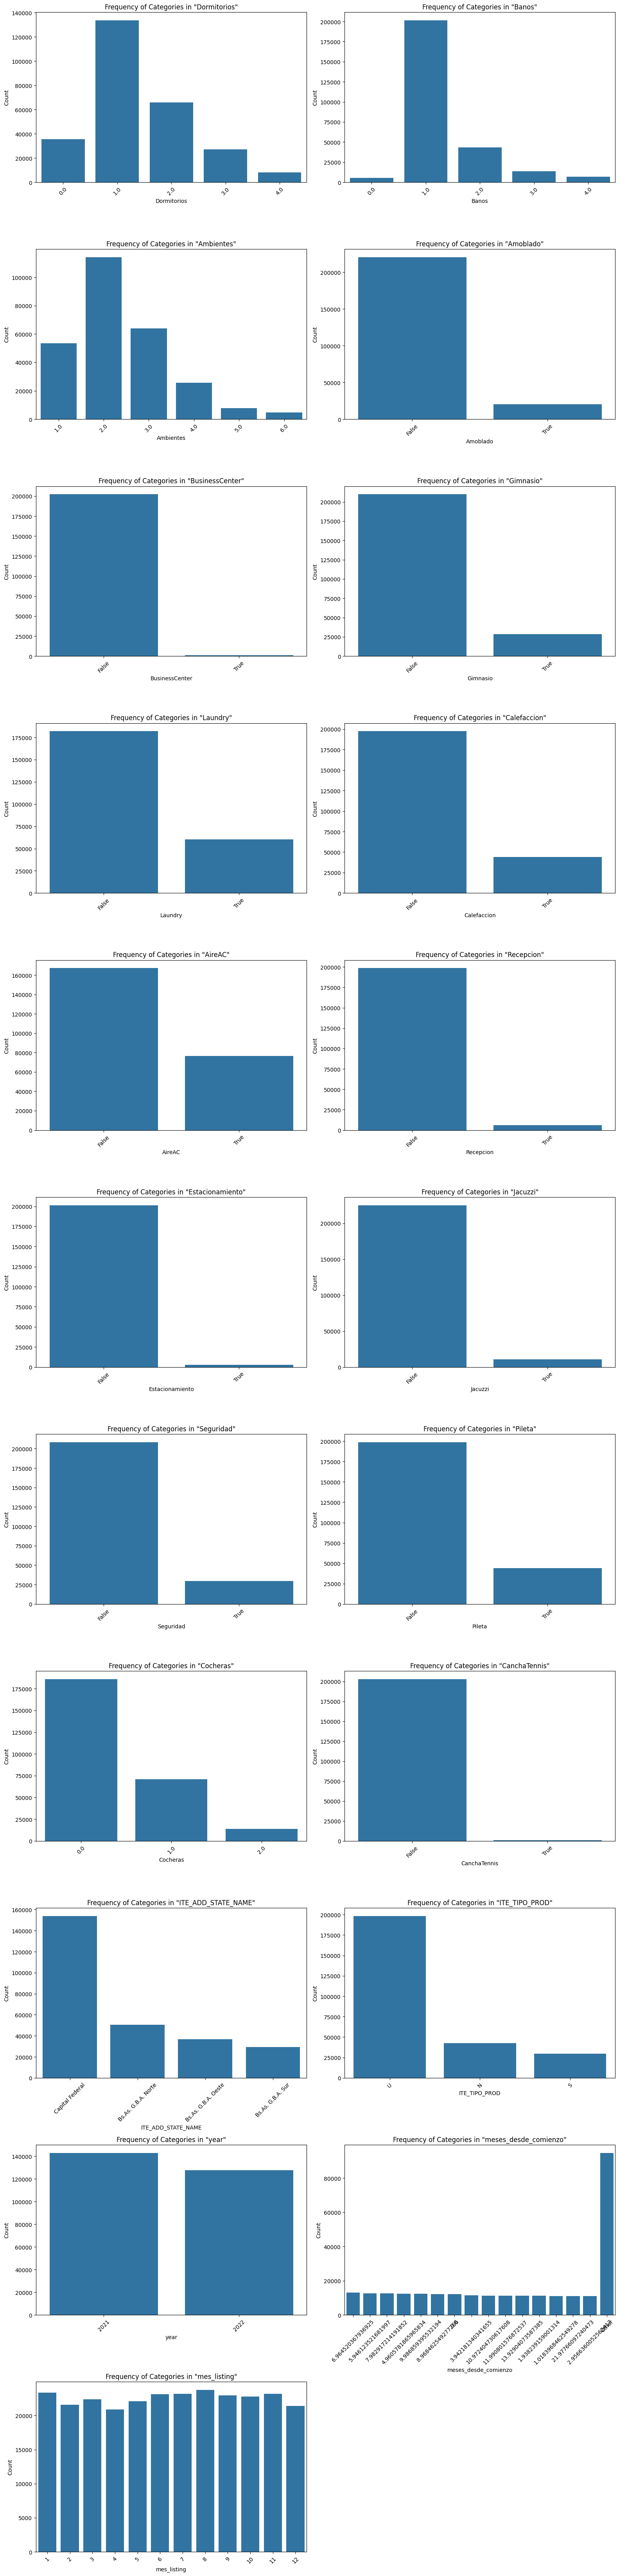

In [14]:
plot_bar_charts(df_capped, CATEGORICAL_FEATURES)

Insights:
- Variables booleanas muy desbalanceadas. Especialmente algunas relacionadas con amenities de lujo, tienen un desbalance extremo, donde solo están presentes en algunas pocas propiedades. Una opción para manejar esto puede ser unificar todas las columnas relacionadas con amenities de lujo en una sola.
- Otras variables categoricas como Ambientes y Dormitorios tienen una forma aproximadamente gaussiana. Probablemente no sean un problema.

## Análisis Geoespacial

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


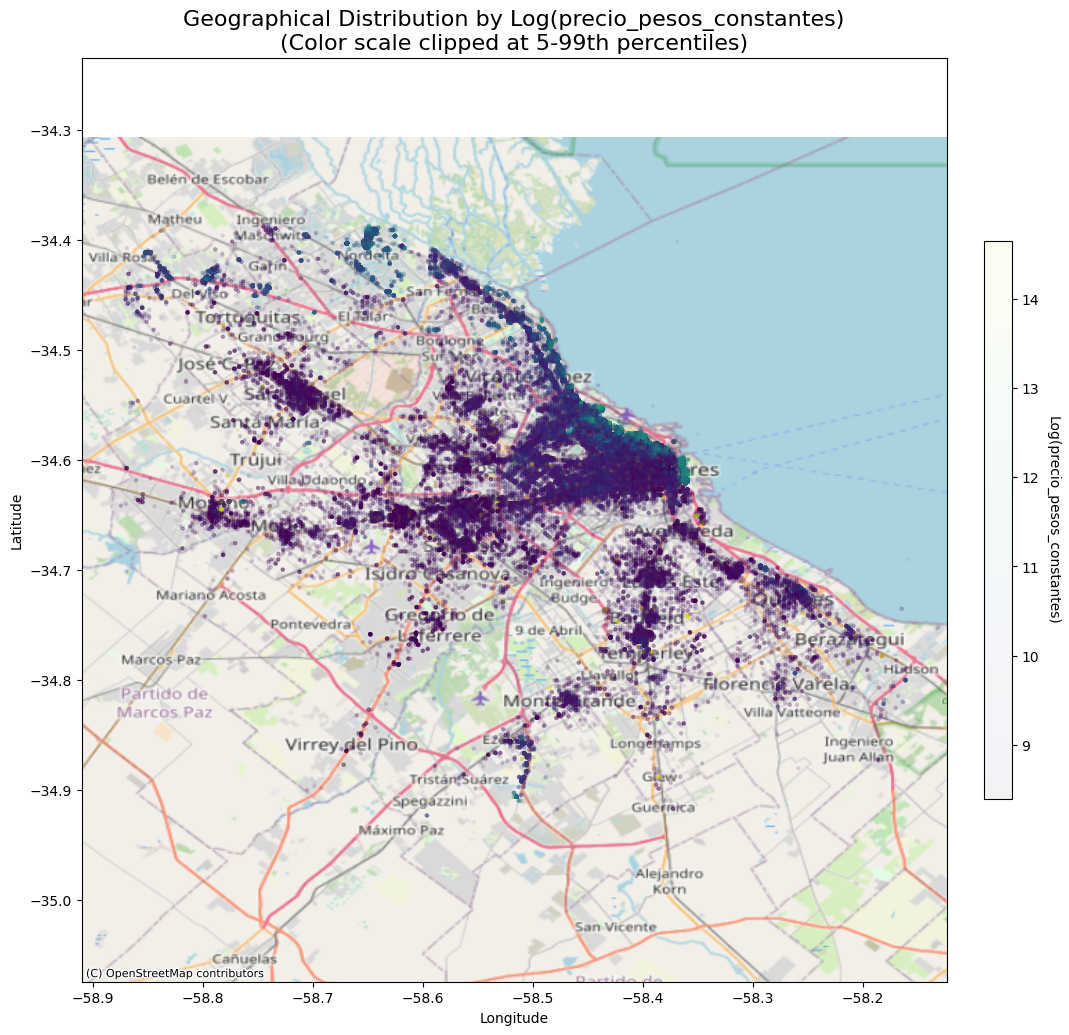

In [26]:
plot_geo_scatterplot(
    df,
    geo_cols=("LONGITUDE", "LATITUDE"),
    color_col=TARGET,
    log_scale=True,
    clip_percentiles=(0.05, 0.99),
    cmap='viridis',
    add_basemap=True,
    alpha=0.05
)